# Differential Expression Gene Analysis


### Init

In [1]:
# load libraryies
library("DESeq2")
library(ggplot2)
options(width=150) # increase the width of the screen output
library(EnhancedVolcano)
library(pheatmap)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading required p

### Original Dataset - DEG of LR vs. NR

In [2]:
dds <- readRDS("dds_batch_condition_3batches_original.rds")
res <- results(dds, contrast=c("condition","NR","LR"))
summary(res)


out of 30978 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 138, 0.45%
LFC < 0 (down)     : 66, 0.21%
outliers [1]       : 78, 0.25%
low counts [2]     : 11238, 36%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [3]:
# export deseq2 analysis results to csv file
write.csv(as.data.frame(res), file="original_dataset_NR_vs_LR_results.csv")

In [4]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 1 (i.e., at least double or half the level of expression)
res05 <- res[which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2)), ]

# sort by padj and write to file
res05Ordered <- res05[order(res05$padj),]
write.csv(as.data.frame(res05Ordered), file="original_dataset_NR_vs_LR_fdr05_fc2_results.csv")

### Filter and sorting results by p-Adj

In [5]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]

In [6]:
res[res_idx_05,]

log2 fold change (MLE): condition NR vs LR 
Wald test p-value: condition NR vs LR 
DataFrame with 120 rows and 6 columns
            baseMean log2FoldChange     lfcSE      stat      pvalue        padj
           <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
OVCH1        5.82442       -5.07543  1.090301  -4.65508 3.23859e-06 1.90958e-03
LINC00200   23.41589       -4.18466  0.886692  -4.71940 2.36542e-06 1.55030e-03
OVCH1-AS1   40.99771       -4.02211  0.774557  -5.19279 2.07168e-07 2.54583e-04
NLRP4       36.60277       -3.74639  0.660036  -5.67604 1.37851e-08 3.01158e-05
DLGAP1-AS5  48.16467       -3.40039  0.901704  -3.77108 1.62545e-04 3.07303e-02
...              ...            ...       ...       ...         ...         ...
IGLV3-10    72.10242        8.24785   1.42207   5.79991 6.63513e-09 1.63075e-05
IGLV7-43   314.28604        9.35302   1.94053   4.81982 1.43689e-06 9.74210e-04
IGHV5-10-1 298.52879        9.75290   2.15928   4.51674 6.27980e-06 3.16598e-03

### VST regularization

In [7]:
vsd <- vst(dds, blind = TRUE)

In [8]:
# export vsd and count matrix log2FoldChange > 1 
# this will be use for ML (predictor)
res_idx_01 <- which(abs(res$log2FoldChange)>1)
length(res_idx_01)

write.csv(as.data.frame(assay(vsd)[res_idx_01,]), file="original_dataset_NR_vs_LR_vsd_results_FC1.csv")
write.csv(as.data.frame(counts(dds)[res_idx_01,]), file="original_dataset_NR_vs_LR_counts_results_FC1.csv")


[1] 1872

### PCA before batch - correction

In [9]:

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("condition", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg1 = ggplot(pcaData, aes(PC1, PC2, color=condition, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

ggplot2::ggsave("original_dataset_NR_vs_LR_PCA before batch correction.eps", plot = gg1)


Saving 6.67 x 6.67 in image



In [10]:
assay(vsd) <- limma::removeBatchEffect(assay(vsd), vsd$batch)
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("condition", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg2 = ggplot(pcaData, aes(PC1, PC2, color=condition, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()
ggplot2::ggsave("original_dataset_NR_vs_LR_PCA After batch correction.eps", plot = gg2)

Saving 6.67 x 6.67 in image



### Heatmap

In [11]:
df <- as.data.frame(colData(dds)[,c("condition", "batch")])
rownames(df)<- rownames(colData(dds))
colnames(df) <- c("Condition", 'Batch')

In [12]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.01 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]
length(res_idx_05)

[1] 56

Saving 6.67 x 6.67 in image



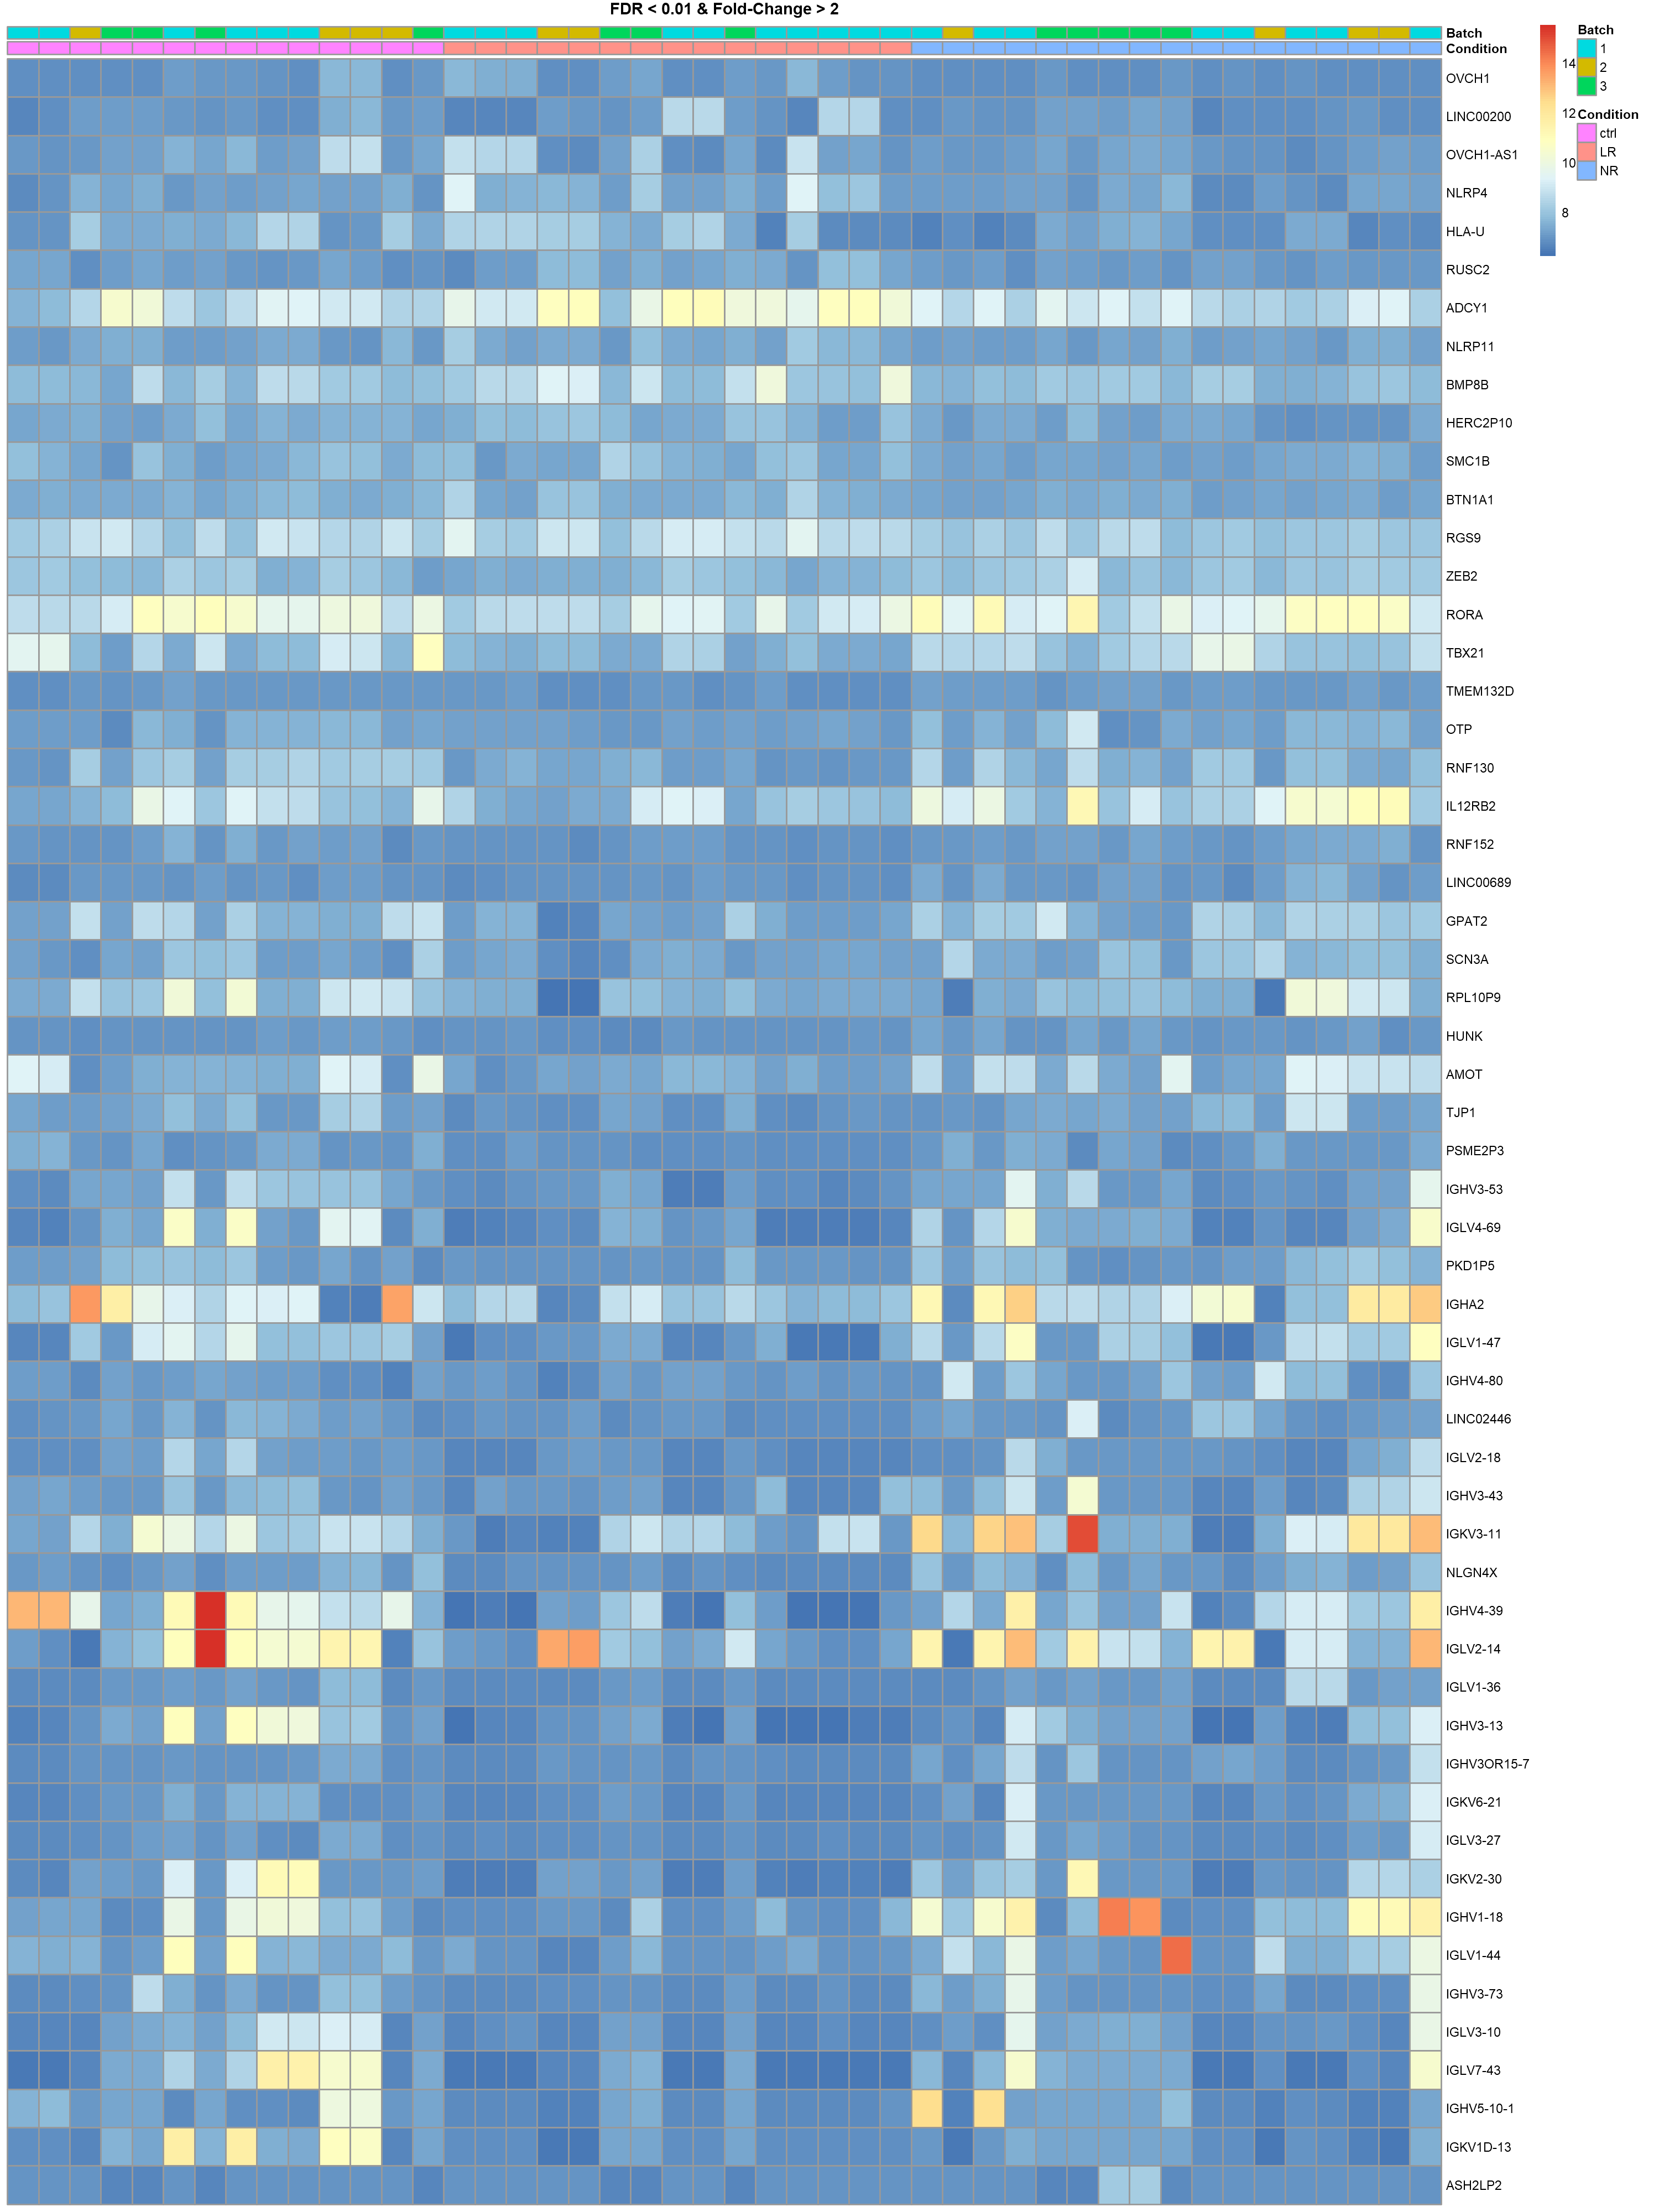

In [13]:
options(repr.plot.width = 15, repr.plot.height = 20, repr.plot.res = 200)
library(pheatmap)


gg33= pheatmap(assay(vsd)[res_idx_05,], 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         display_numbers = FALSE, 
         annotation_col = df,
         fontsize = 8,
         main = "FDR < 0.01 & Fold-Change > 2")
ggplot2::ggsave("original_dataset_NR_vs_LR Heatmap_less_genes.eps", plot = gg33)


#### Order by log2FoldChange

In [14]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]

In [15]:
log2(2)

[1] 1

Saving 6.67 x 6.67 in image



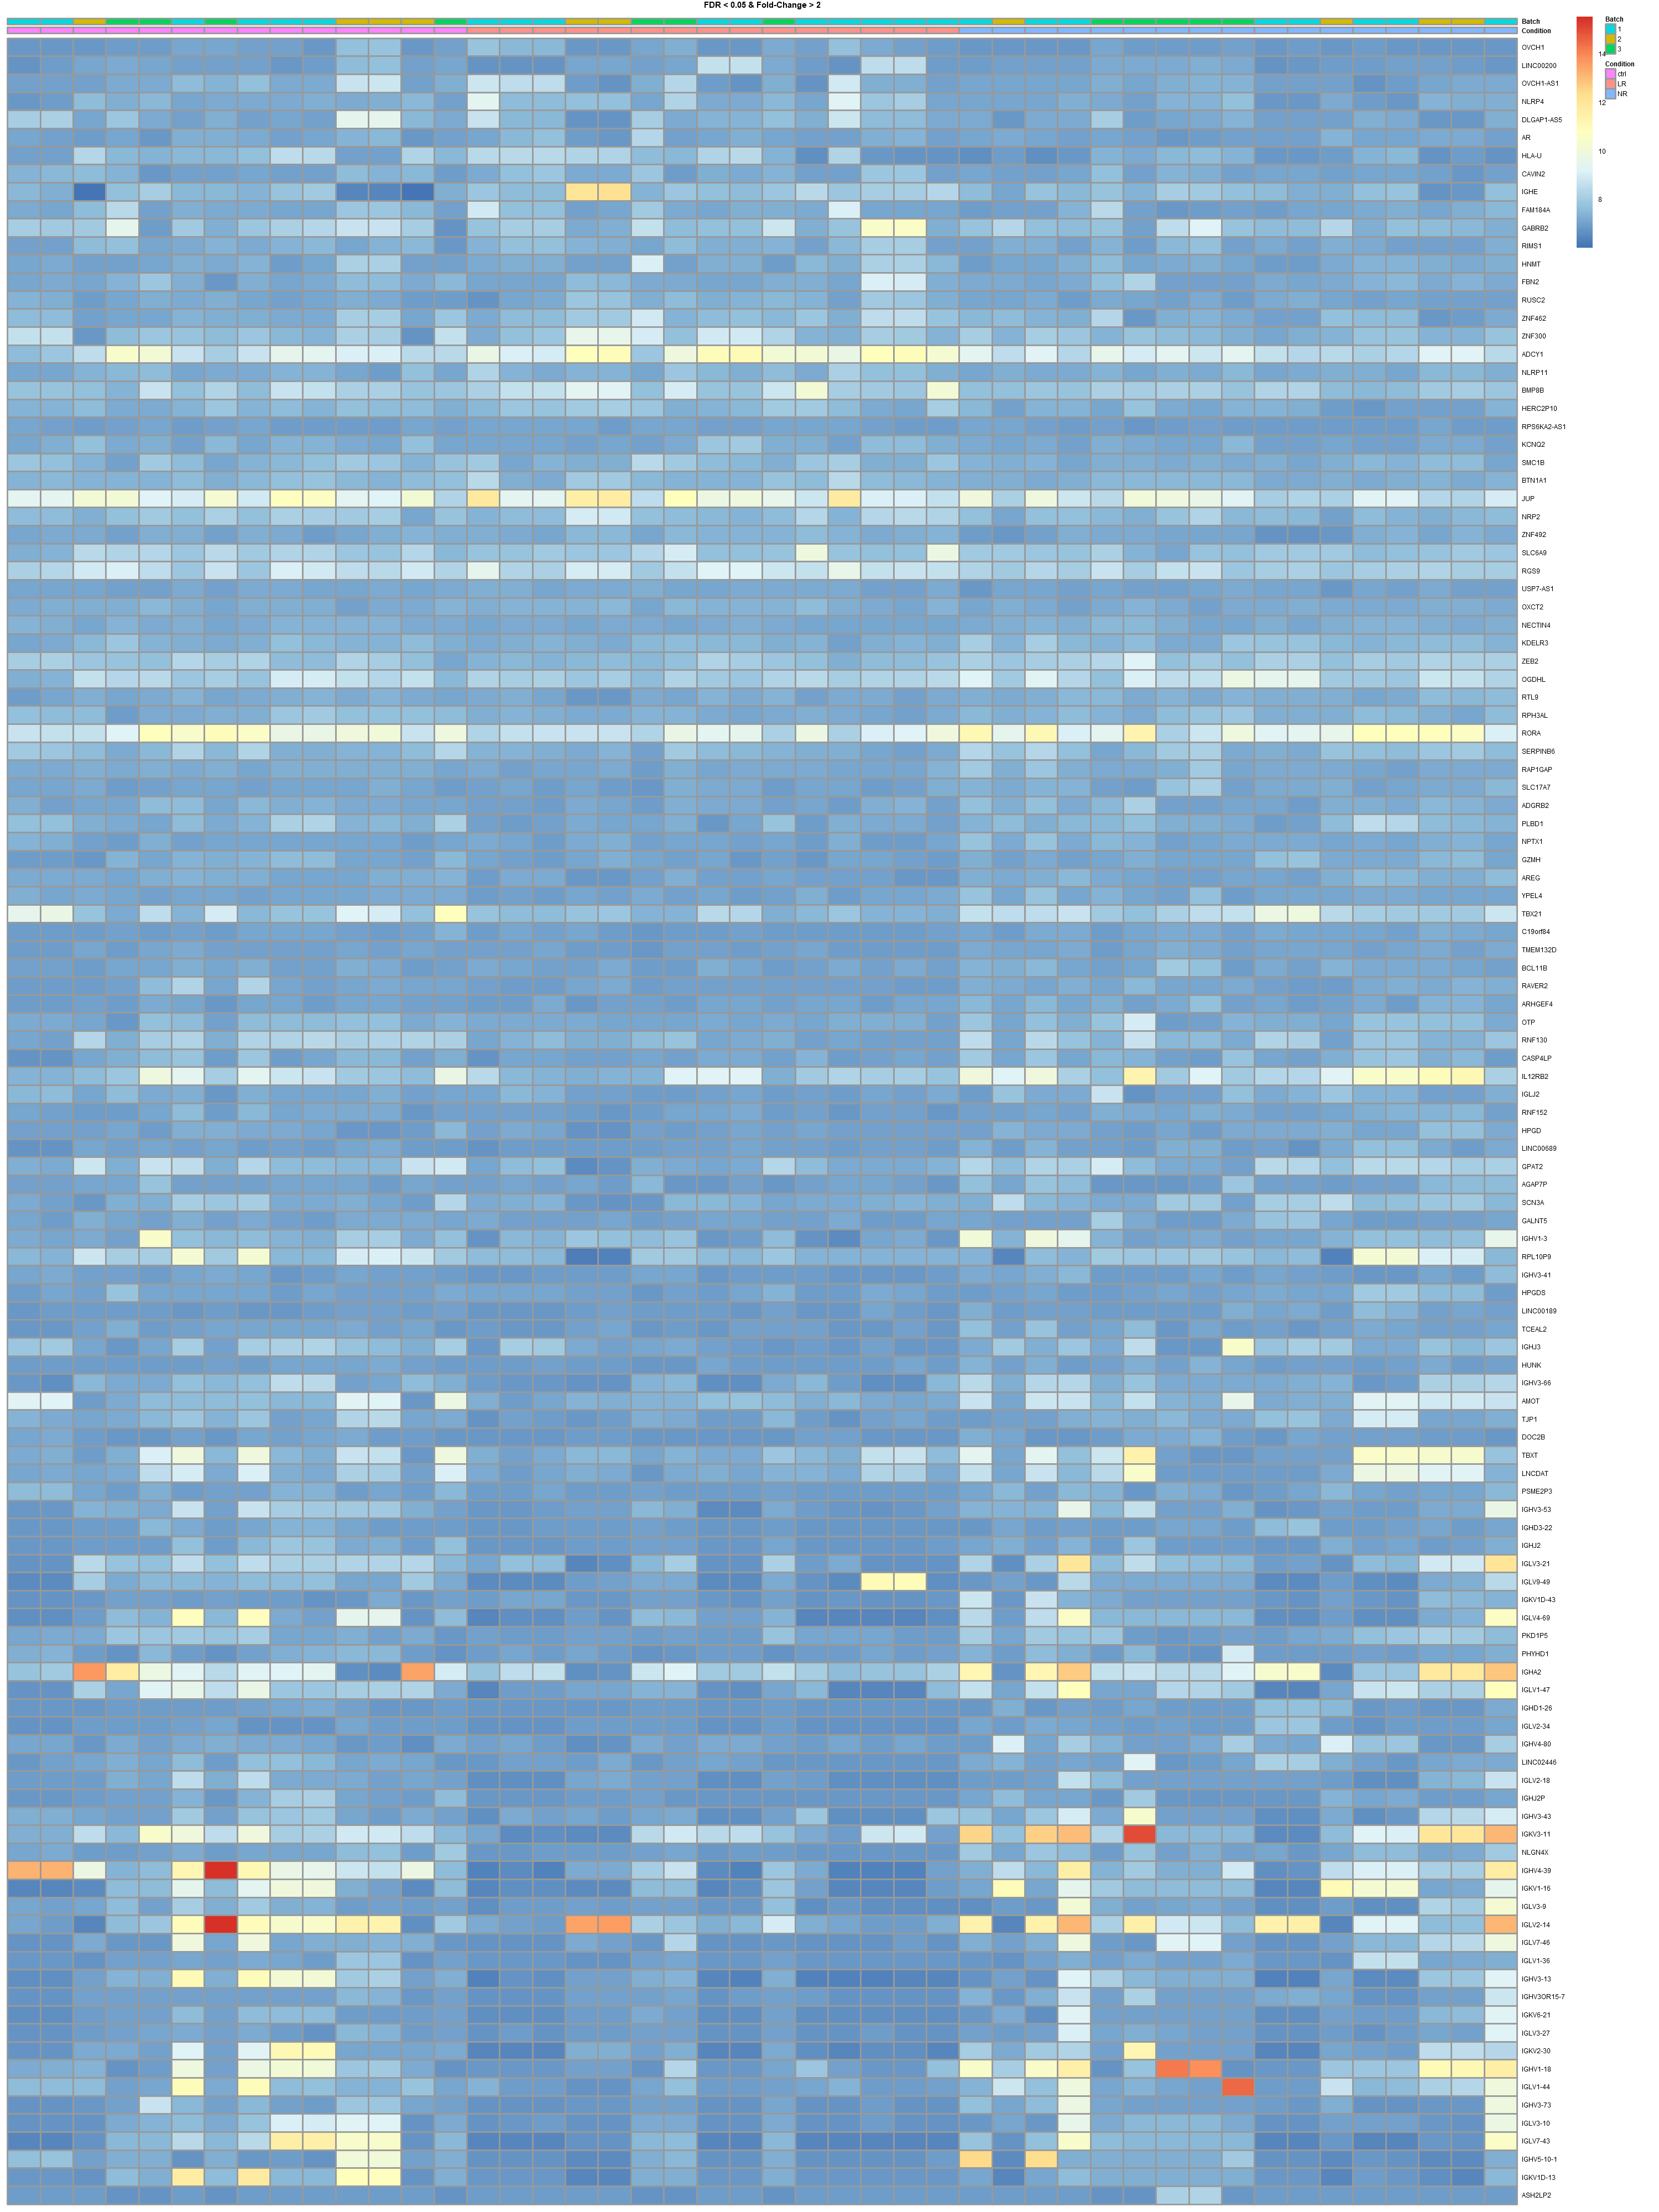

In [16]:
options(repr.plot.width = 15, repr.plot.height = 20, repr.plot.res = 200)
library(pheatmap)


gg3= pheatmap(assay(vsd)[res_idx_05,], 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         display_numbers = FALSE, 
         annotation_col = df,
         fontsize = 4,
         main = "FDR < 0.05 & Fold-Change > 2")
ggplot2::ggsave("original_dataset_NR_vs_LR Heatmap_small_font.eps", plot = gg3)


### Volcano Plot

In [17]:

options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 300)
gg4 = EnhancedVolcano(res,
                lab = rownames(res),
                #selectLab = rownames(res[res_idx_05,]),
                x = 'log2FoldChange',
                y = 'pvalue', 
                pCutoffCol = 'padj',
                pCutoff = 0.05,
                FCcutoff = 1,
                ylim = c(0, -log10(10e-9)),
                xlim = c(-7, 10),
                pointSize = c(ifelse(res$padj<0.05 & abs(res$log2FoldChange)>log2(2), 1.5, 0.75)), 
                labSize = 2.0, 
                title = 'NR vs LR',
                subtitle = 'Differential expression',
                caption = 'FC cutoff, 2.0; p-adj cutoff, 0.05',
                colAlpha = 1.0, 
                legendPosition = "top",
                legendLabSize = 10,
                legendIconSize = 2, 
                legendLabels = c("NS", expression(Log[2] ~ FC), "p-Adj", expression(P-adj ~ "&" ~ log[2] ~ FC)),
               )
ggplot2::ggsave("original_dataset_NR_vs_LR Volcano Plot.eps", plot = gg4)

Saving 6.67 x 6.67 in image



### plotCounts

#### FDR (padj) < 0.05 & Fold-change > 2.0 

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res =200)

res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]


pdf("original_dataset_NR_vs_LR plotCounts.pdf", width = 16 , height = 10, title = "plotCounts : NR_vs_LR ")
gg5 = attach(mtcars)
par(mfrow=c(4,4))
for (gene in rownames(res[res_idx_05,])) {
    plotCounts(dds, gene=gene, intgroup="condition")
    }

dev.off()

The following object is masked from package:ggplot2:

    mpg




png 
  2

=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================
=====================================================================================

### Joines Dataset - DEG of LR vs. NR

In [19]:
dds <- readRDS("dds_batch_condition_4batches_joined.rds")
res <- results(dds, contrast=c("condition","NR","LR"))
summary(res)


out of 32702 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 52, 0.16%
LFC < 0 (down)     : 21, 0.064%
outliers [1]       : 59, 0.18%
low counts [2]     : 14407, 44%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [20]:
# export deseq2 analysis results to csv file
write.csv(as.data.frame(res), file="joined_dataset_NR_vs_LR_results.csv")

In [21]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 1 (i.e., at least double or half the level of expression)
res05 <- res[which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2)), ]

# sort by padj and write to file
res05Ordered <- res05[order(res05$padj),]
write.csv(as.data.frame(res05Ordered), file="joined_dataset_NR_vs_LR_fdr05_fc2_results.csv")

### Filter and sorting results by p-Adj

In [22]:
# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]

In [23]:
res[res_idx_05,]

log2 fold change (MLE): condition NR vs LR 
Wald test p-value: condition NR vs LR 
DataFrame with 31 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
HLA-U       58.7540       -2.73802  0.617456  -4.43435 9.23500e-06   0.0105256
TRAT1       21.7145       -2.73007  0.660760  -4.13172 3.60060e-05   0.0285481
OVCH1-AS1   23.1289       -2.64353  0.594372  -4.44761 8.68315e-06   0.0105256
MTUS1       25.3277       -2.08841  0.514199  -4.06148 4.87623e-05   0.0342011
IL18        11.0832       -1.74267  0.438064  -3.97811 6.94664e-05   0.0423650
...             ...            ...       ...       ...         ...         ...
IGLV7-46   98.02610        4.87082  1.067281   4.56377 5.02428e-06 7.09855e-03
IGLV3-10   76.57320        5.07110  1.009012   5.02581 5.01312e-07 1.52365e-03
IGLV2-18   50.18906        5.18660  0.856817   6.05333 1.41884e-09 8.59864e-06
IGHV4-80   

### VST regularization

In [24]:
vsd <- vst(dds, blind = TRUE)

In [25]:
# export vsd and count matrix log2FoldChange > 1 
# this will be use for ML (predictor)
res_idx_01 <- which(abs(res$log2FoldChange)>1)
length(res_idx_01)

write.csv(as.data.frame(assay(vsd)[res_idx_01,]), file="joined_dataset_NR_vs_LR_vsd_results_FC1.csv")
write.csv(as.data.frame(counts(dds)[res_idx_01,]), file="joined_dataset_NR_vs_LR_counts_results_FC1.csv")


[1] 753

### PCA before batch - correction

In [26]:

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("condition", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg1 = ggplot(pcaData, aes(PC1, PC2, color=condition, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

ggplot2::ggsave("joined_dataset_NR_vs_LR_PCA before batch correction.eps", plot = gg1)

Saving 6.67 x 6.67 in image



### PCA afer batch - correction

In [27]:
assay(vsd) <- limma::removeBatchEffect(assay(vsd), vsd$batch)

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
pcaData <- plotPCA(vsd, intgroup=c("condition", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
gg2 = ggplot(pcaData, aes(PC1, PC2, color=condition, shape=batch)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()
ggplot2::ggsave("joined_dataset_NR_vs_LR_PCA after batch correction.eps", plot = gg2)

Saving 6.67 x 6.67 in image



### Heatmap

In [28]:
df <- as.data.frame(colData(dds)[,c("condition", "batch")])
rownames(df)<- rownames(colData(dds))
colnames(df) <- c("Condition", 'Batch')

#### Order by log2FoldChange

Saving 6.67 x 6.67 in image



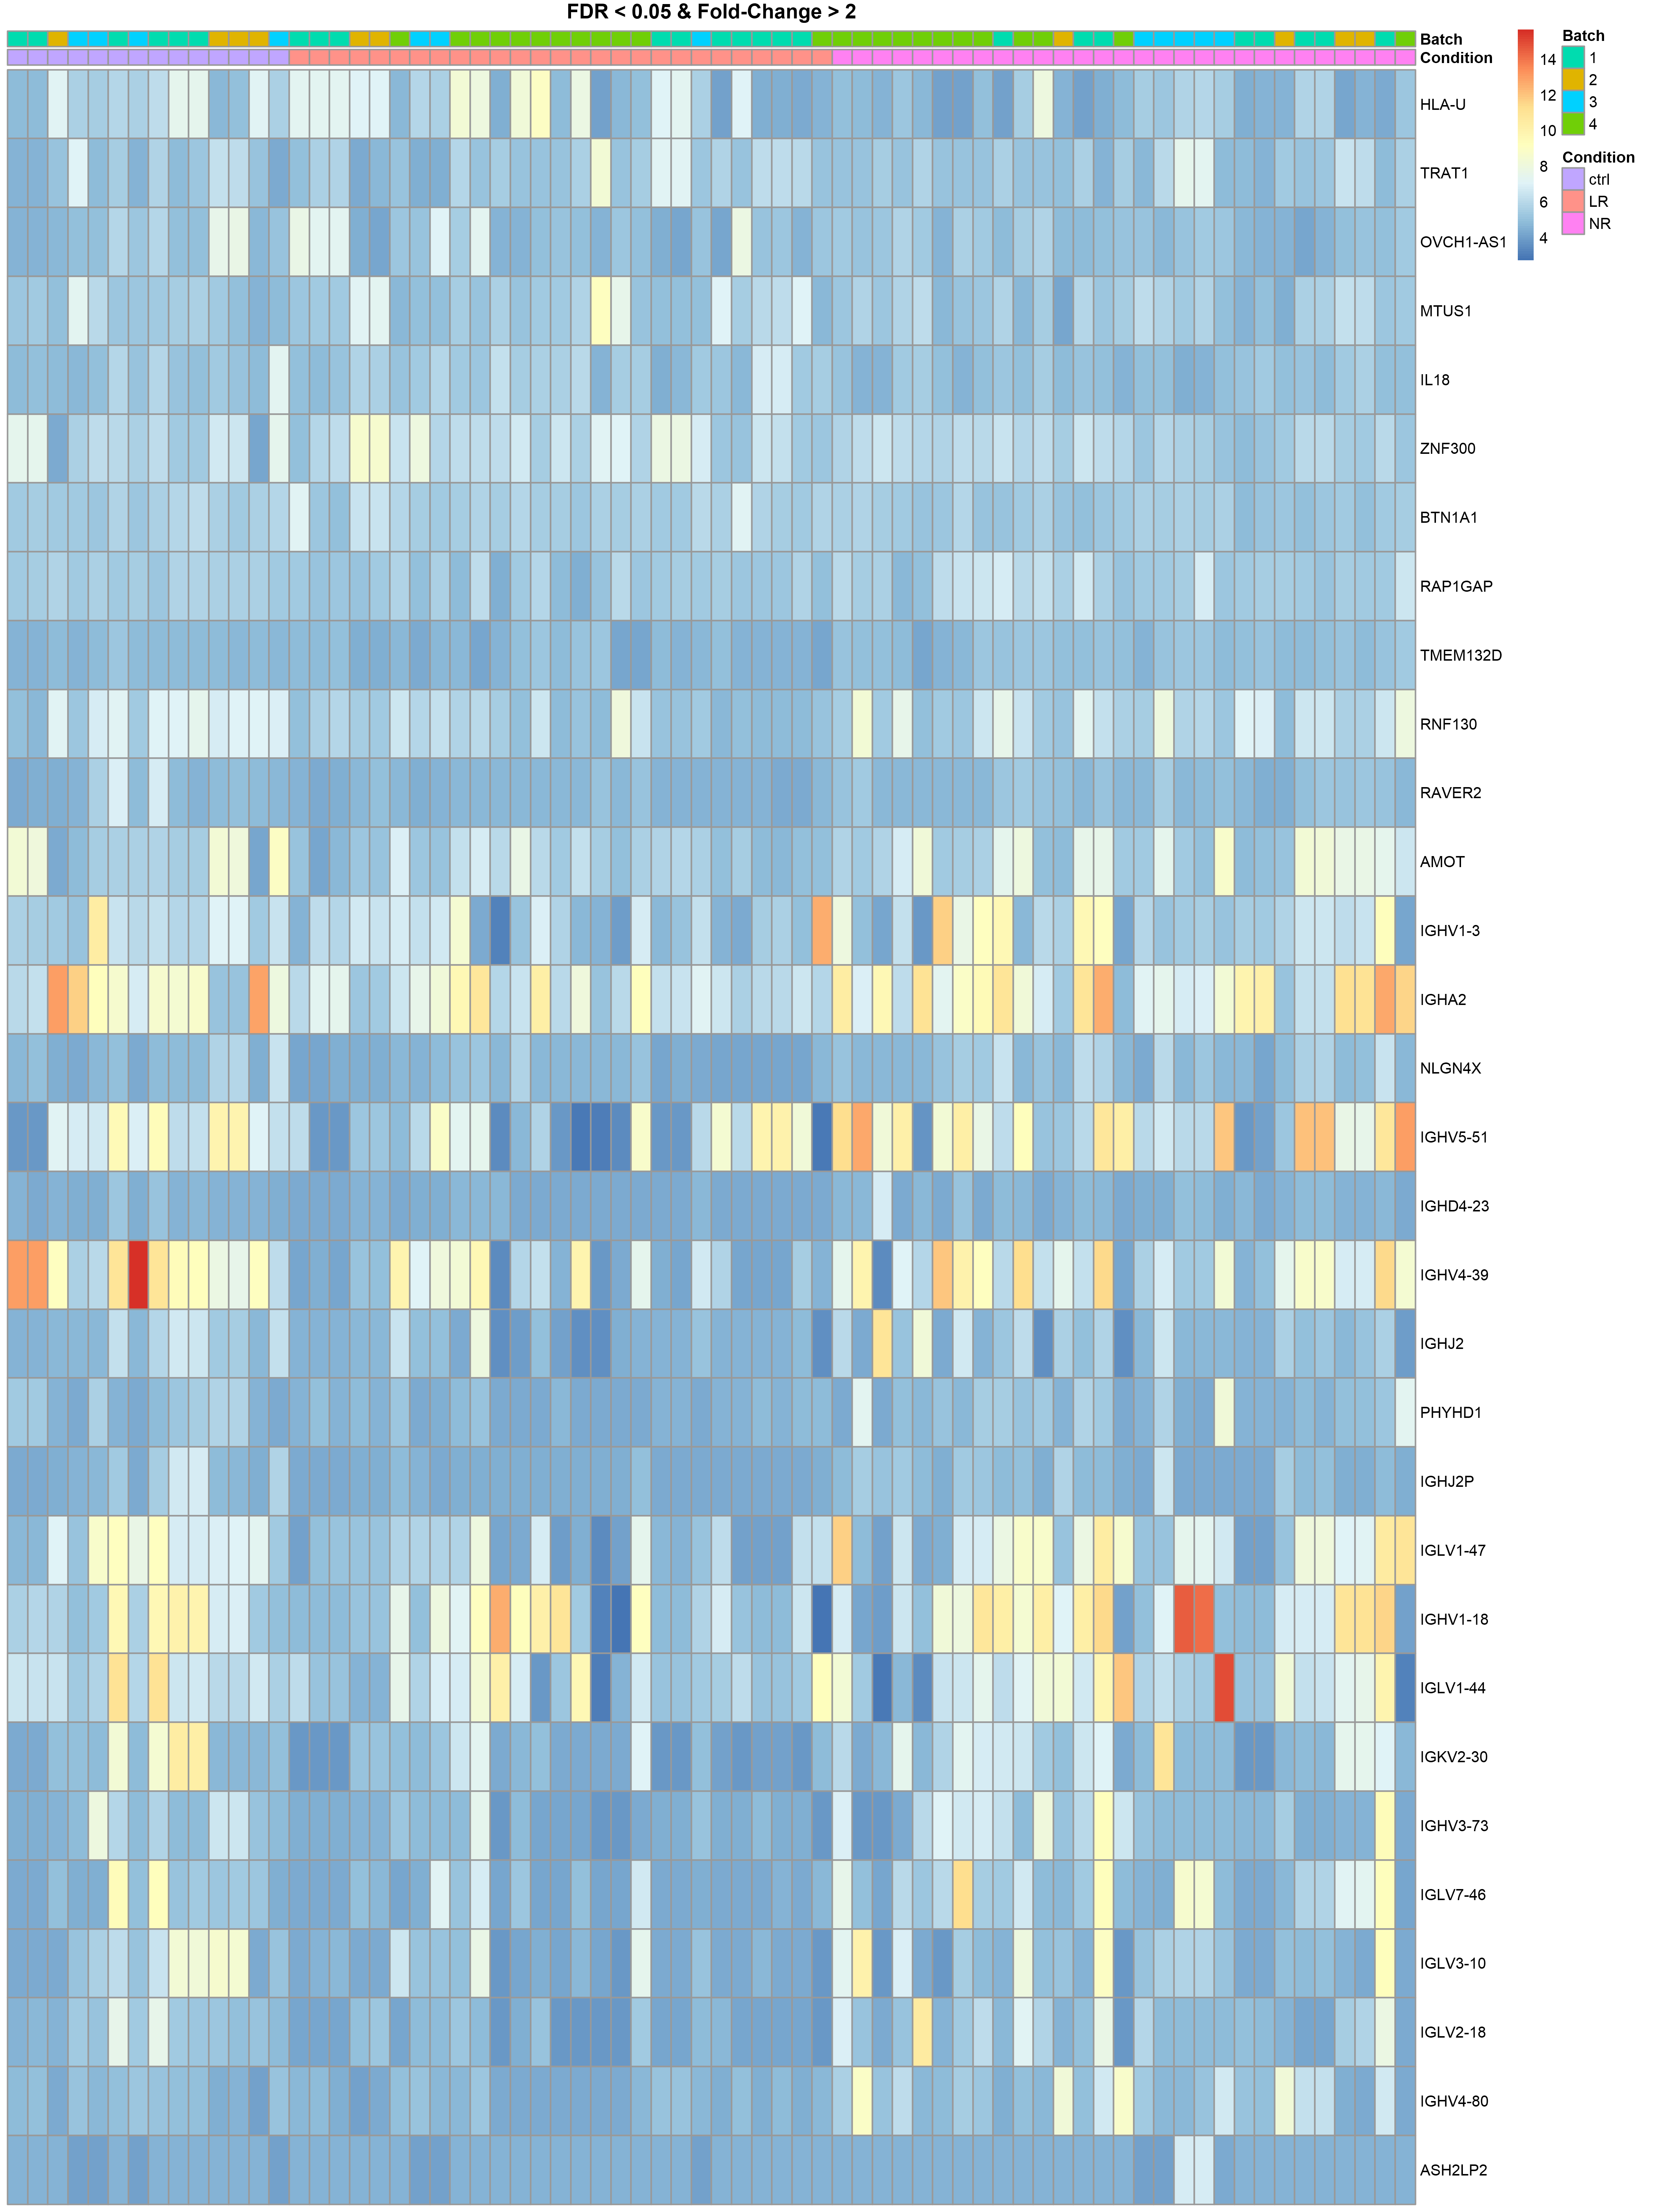

In [29]:

# Filter the results for FDR < 0.05 and 
#  absolute value of Fold-Change > 2 (i.e., at least double or half the level of expression)
res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
# order by log2FoldChange and keep indecis
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]


options(repr.plot.width = 15, repr.plot.height = 20, repr.plot.res = 200)



options(repr.plot.width = 15, repr.plot.height = 20, repr.plot.res = 300)
library(pheatmap)
gg3= pheatmap(assay(vsd)[res_idx_05,], 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         display_numbers = FALSE, 
         annotation_col = df,
         main = "FDR < 0.05 & Fold-Change > 2")
ggplot2::ggsave("joined_dataset_NR_vs_LR heatmap.eps", plot = gg3)

### Volcano Plot

In [30]:


options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 300)
gg4 = EnhancedVolcano(res,
                lab = rownames(res),
                #selectLab = rownames(res[res_idx_05,]),
                x = 'log2FoldChange',
                y = 'pvalue', 
                pCutoffCol = 'padj',
                pCutoff = 0.05,
                FCcutoff = 1,
                ylim = c(0, -log10(10e-9)),
                xlim = c(-7, 10),
                pointSize = c(ifelse(res$padj<0.05 & abs(res$log2FoldChange)>log2(2), 1.5, 0.75)), 
                labSize = 2.0, 
                title = 'NR vs LR',
                subtitle = 'Differential expression',
                caption = 'FC cutoff, 2.0; p-adj cutoff, 0.05',
                colAlpha = 1.0, 
                legendPosition = "top",
                legendLabSize = 10,
                legendIconSize = 2, 
                legendLabels = c("NS", expression(Log[2] ~ FC), "p-Adj", expression(P-adj ~ "&" ~ log[2] ~ FC)),
               )
ggplot2::ggsave("joined_dataset_NR_vs_LR Volcano Plot.eps", plot = gg4)

Saving 6.67 x 6.67 in image



### plotCounts

#### FDR (padj) < 0.05 & Fold-change > 2.0 

In [31]:


options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res =200)

res_idx_05 <- which(res$padj<0.05 & abs(res$log2FoldChange)>log2(2))
res_idx_05 <- res_idx_05[order(res[res_idx_05,]$log2FoldChange)]

pdf("joined_dataset_NR_vs_LR plotCounts.pdf", width = 16 , height = 10, title = "plotCounts : NR_vs_LR ")
gg5 = attach(mtcars)
par(mfrow=c(4,4))
for (gene in rownames(res[res_idx_05,])) {
    plotCounts(dds, gene=gene, intgroup="condition")
    }

dev.off()


The following objects are masked from mtcars (pos = 3):

    am, carb, cyl, disp, drat, gear, hp, mpg, qsec, vs, wt


The following object is masked from package:ggplot2:

    mpg




png 
  2

# SCN11A Gene (appendix)

In [32]:
res['SCN11A',]

log2 fold change (MLE): condition NR vs LR 
Wald test p-value: condition NR vs LR 
DataFrame with 1 row and 6 columns
        baseMean log2FoldChange     lfcSE      stat    pvalue      padj
       <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
SCN11A   4.65352      -0.078918  0.257661 -0.306286  0.759387  0.974882

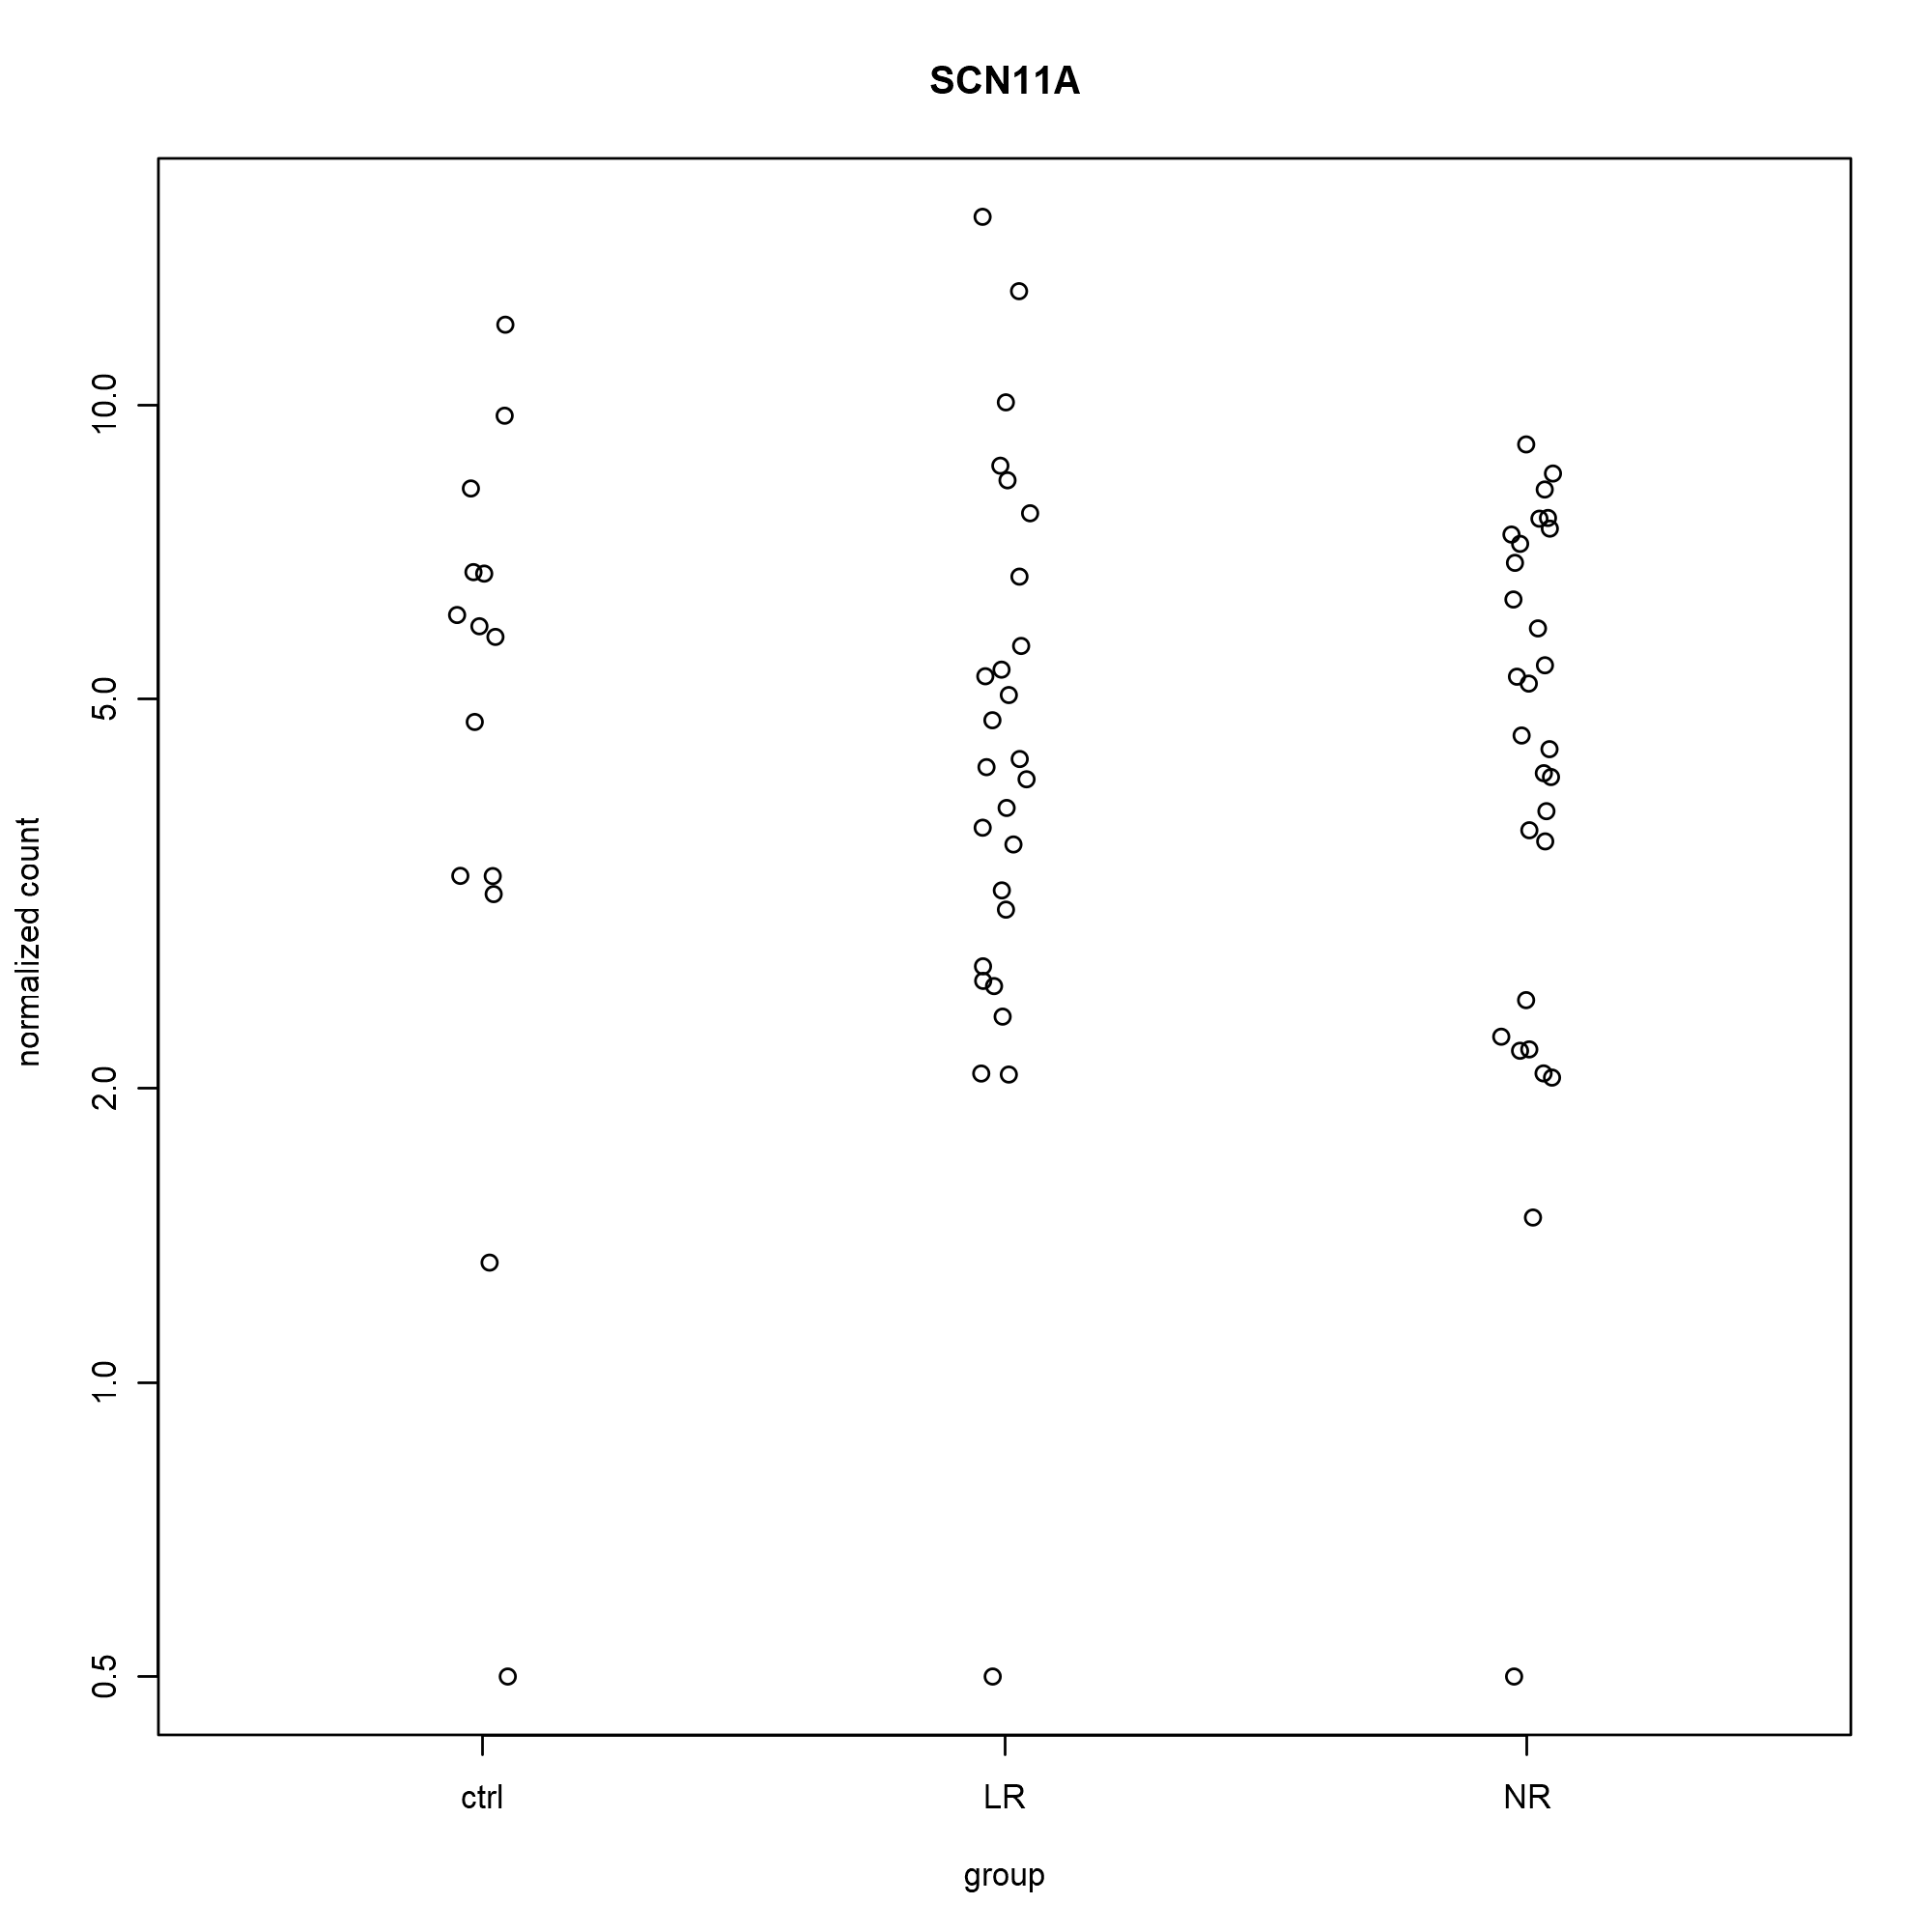

In [33]:
gene = 'SCN11A'
plotCounts(dds, gene=gene, intgroup="condition", )

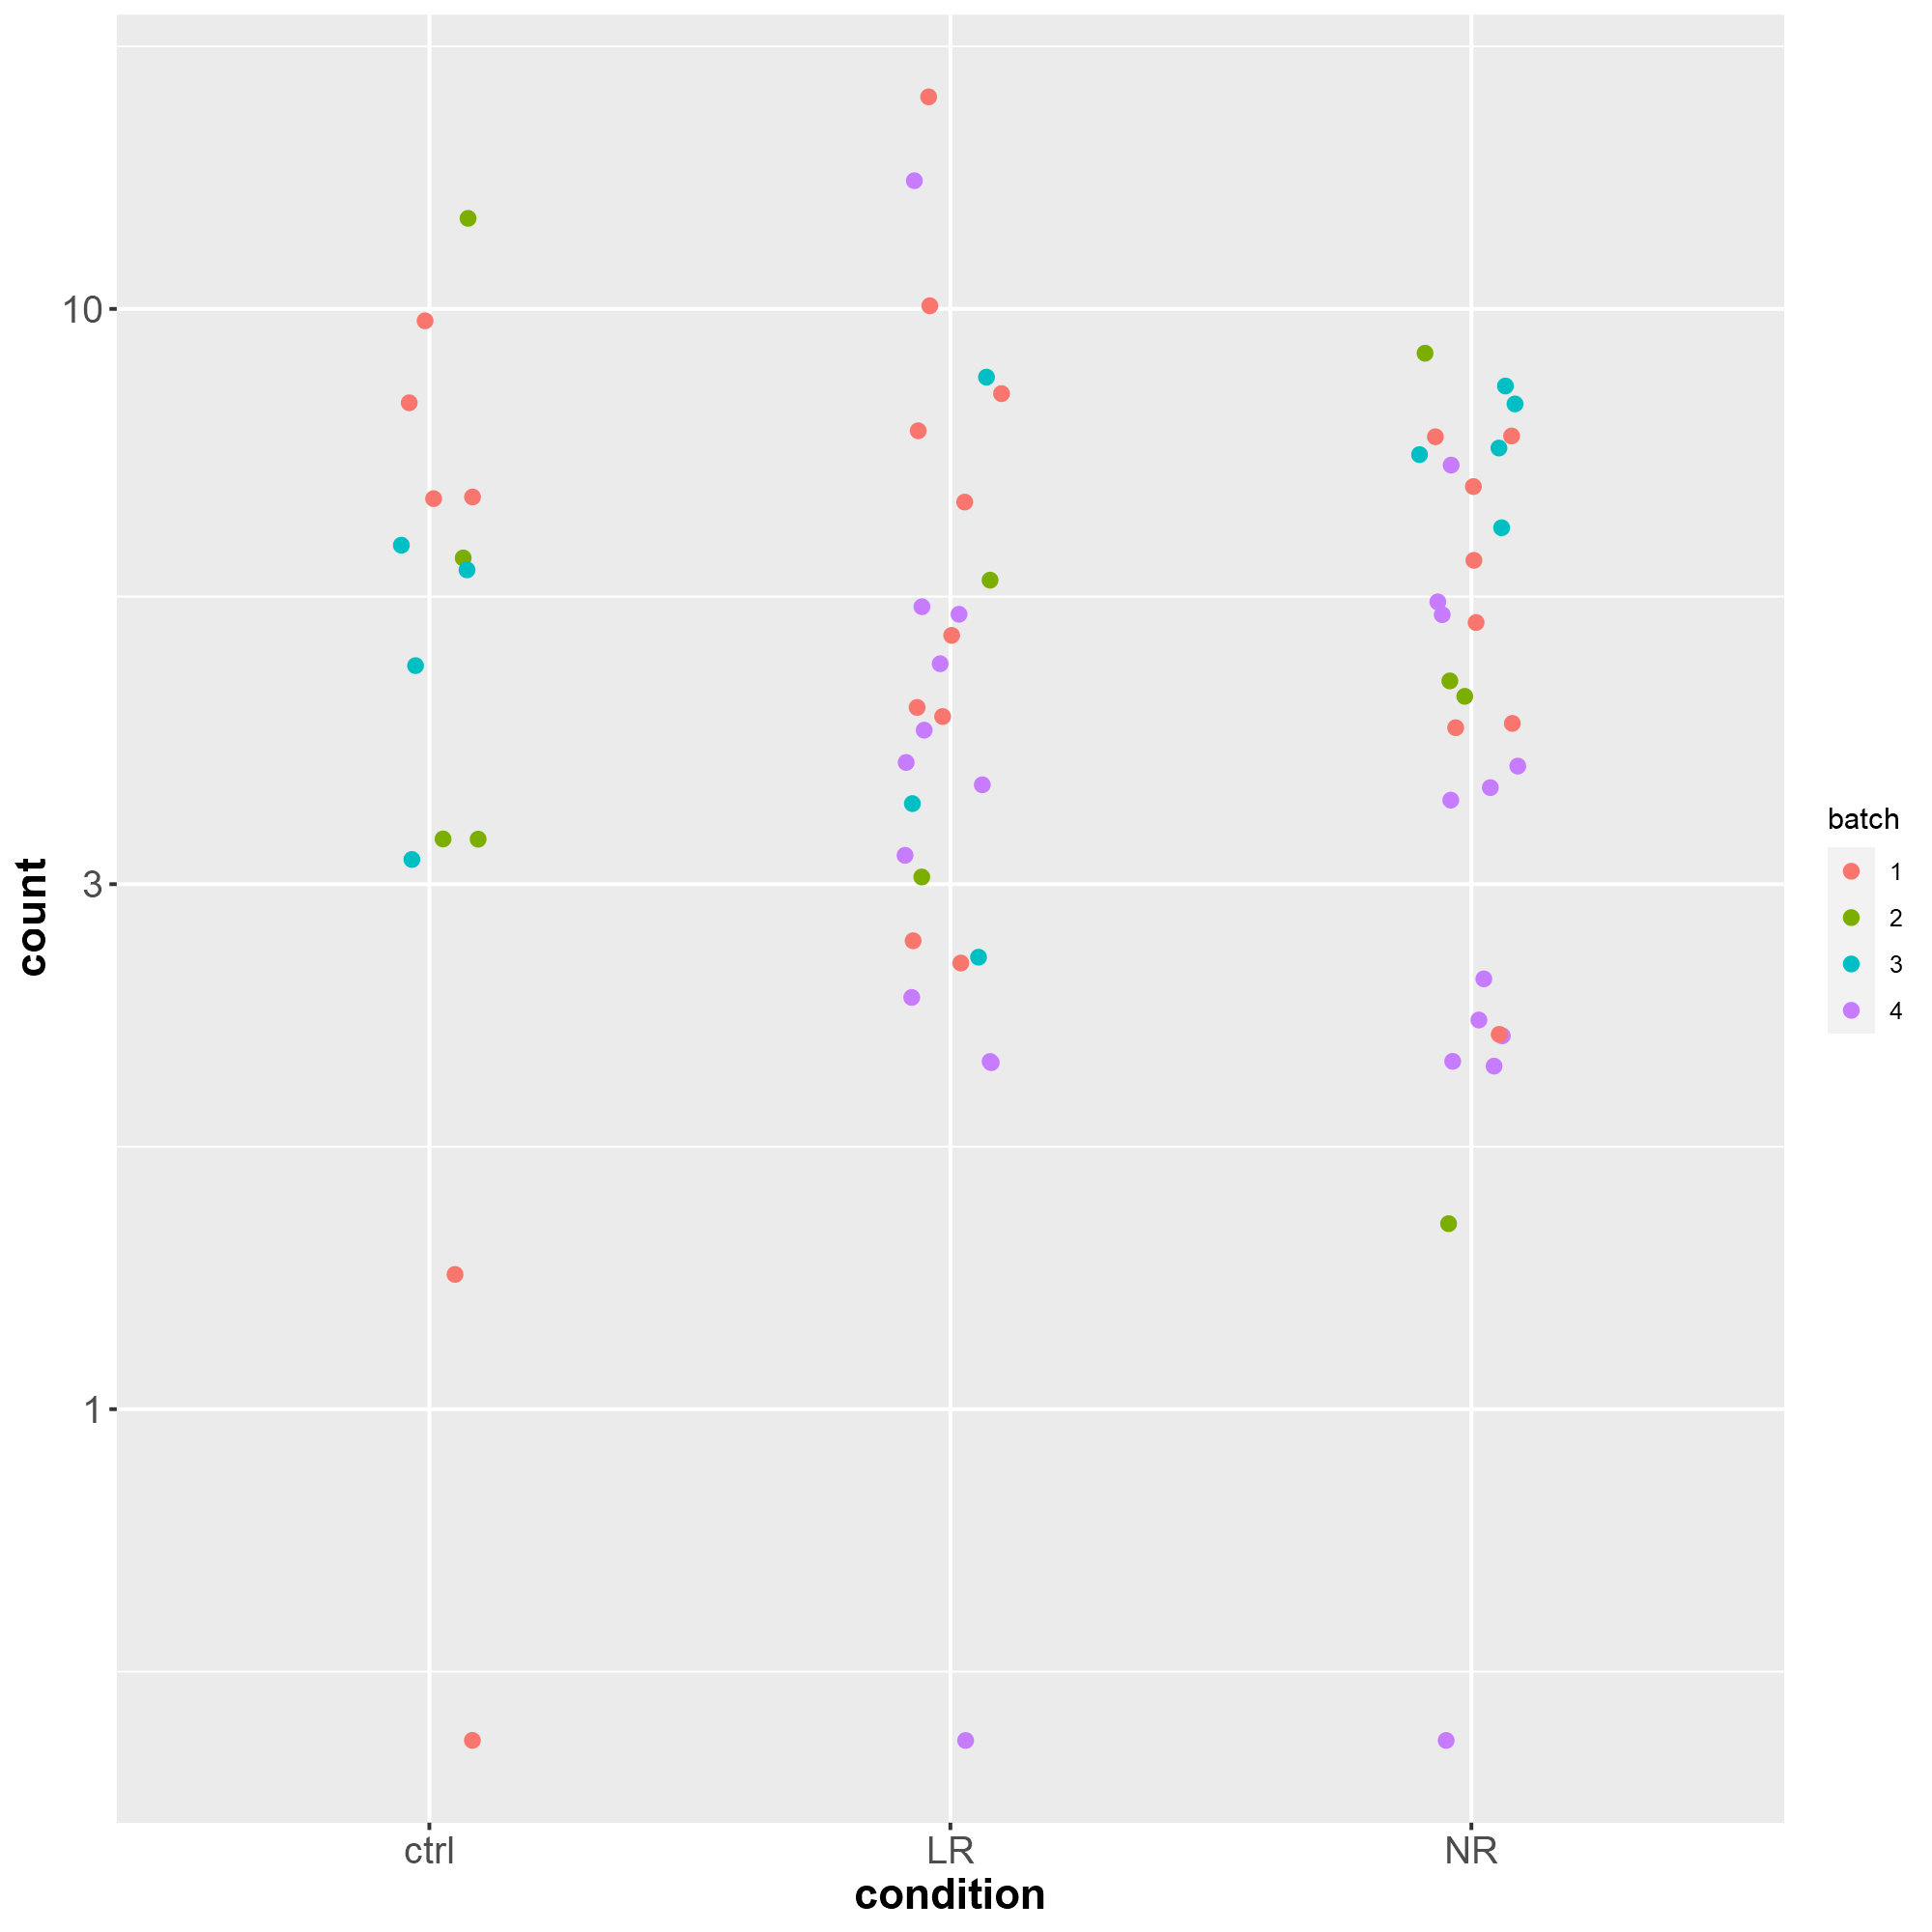

In [34]:
data <- plotCounts(dds, 
                   gene = gene,
                   intgroup = c("condition","batch"), 
                   returnData = TRUE)

ggplot(data, aes(x=condition,  y=count, color=batch)) + 
          geom_jitter(width = 0.1, size=2) + 
          scale_y_log10() + 
          theme(axis.text=element_text(size=14),
                axis.title=element_text(size=16,face="bold"))